In [ ]:
!pip install ultralytics  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install keras-ocr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 64.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
import matplotlib.pyplot as plt
import cv2
import keras_ocr
import numpy as np
from PIL import Image
import glob
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow

In [ ]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

In [ ]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'num', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    return image #if used in Colab
  else :
    cv2.imshow(image) #if used in Python

In [ ]:
img_fns = glob.glob('/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/*.png')

In [ ]:
def read_img(images_path):
    images = [Image.open(image) for image in images_path]
    # This turns images into (image, scale) tuples temporarily
    images = [
        np.asarray(image)
        for image in images
    ]
    return images

In [ ]:
images = read_img(img_fns)

In [ ]:
len(images)

100

In [ ]:
model_path = '/content/drive/MyDrive/Yolov8-LicensePlate/runs/detect/train/weights/best.pt'

# Load a pretrained YOLOv8n model
model = YOLO('/content/drive/MyDrive/Yolov8-LicensePlate/runs/detect/train/weights/best.pt')
# image_path = '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest49.png'
# image = Image.open(image_path)
# image = np.asarray(image)

# Run batched inference on a list of images
results = model.predict(img_fns)  # return a list of Results objects

# # Process results list
# for result in results:
#     boxes = result.boxes  # Boxes object for bbox outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Class probabilities for classification outputs



0: 640x640 3 license-plate-numbers, 1: 640x640 (no detections), 2: 640x640 3 license-plate-numbers, 3: 640x640 2 license-plate-numbers, 4: 640x640 1 license-plate-number, 5: 640x640 3 license-plate-numbers, 6: 640x640 3 license-plate-numbers, 7: 640x640 3 license-plate-numbers, 8: 640x640 3 license-plate-numbers, 9: 640x640 3 license-plate-numbers, 10: 640x640 3 license-plate-numbers, 11: 640x640 2 license-plate-numbers, 12: 640x640 3 license-plate-numbers, 13: 640x640 3 license-plate-numbers, 14: 640x640 5 license-plate-numbers, 15: 640x640 (no detections), 16: 640x640 3 license-plate-numbers, 17: 640x640 3 license-plate-numbers, 18: 640x640 (no detections), 19: 640x640 3 license-plate-numbers, 20: 640x640 3 license-plate-numbers, 21: 640x640 4 license-plate-numbers, 22: 640x640 3 license-plate-numbers, 23: 640x640 3 license-plate-numbers, 24: 640x640 3 license-plate-numbers, 25: 640x640 (no detections), 26: 640x640 3 license-plate-numbers, 27: 640x640 3 license-plate-numbers, 28: 64

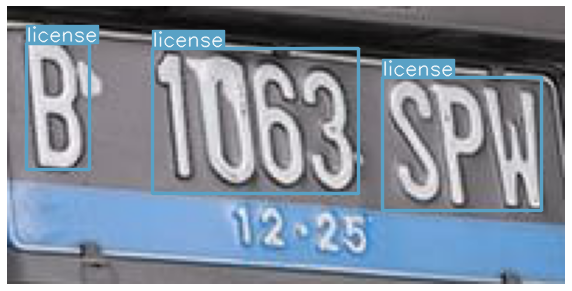

In [ ]:
plot_bboxes(images[89], results[89].boxes.data, score=False)

In [ ]:
img_fns[start_index:end_index]

['/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest92.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest96.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest35.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest83.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest11.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest51.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest25.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest63.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest84.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest49.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest37.png',
 '/content/drive/MyDrive/Yolov8-LicensePlate/bg udh bg/eval_set/DataTest97.png',
 '/content/drive/MyDrive/Yol

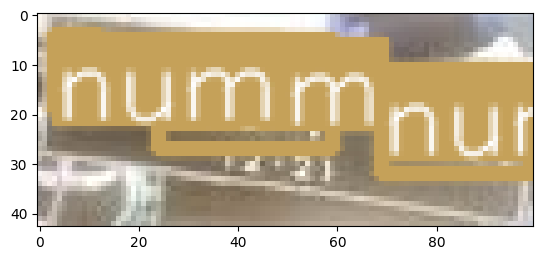

In [ ]:
plt.imshow(plot_bboxes(images[97], results[97].boxes.data, score=False))

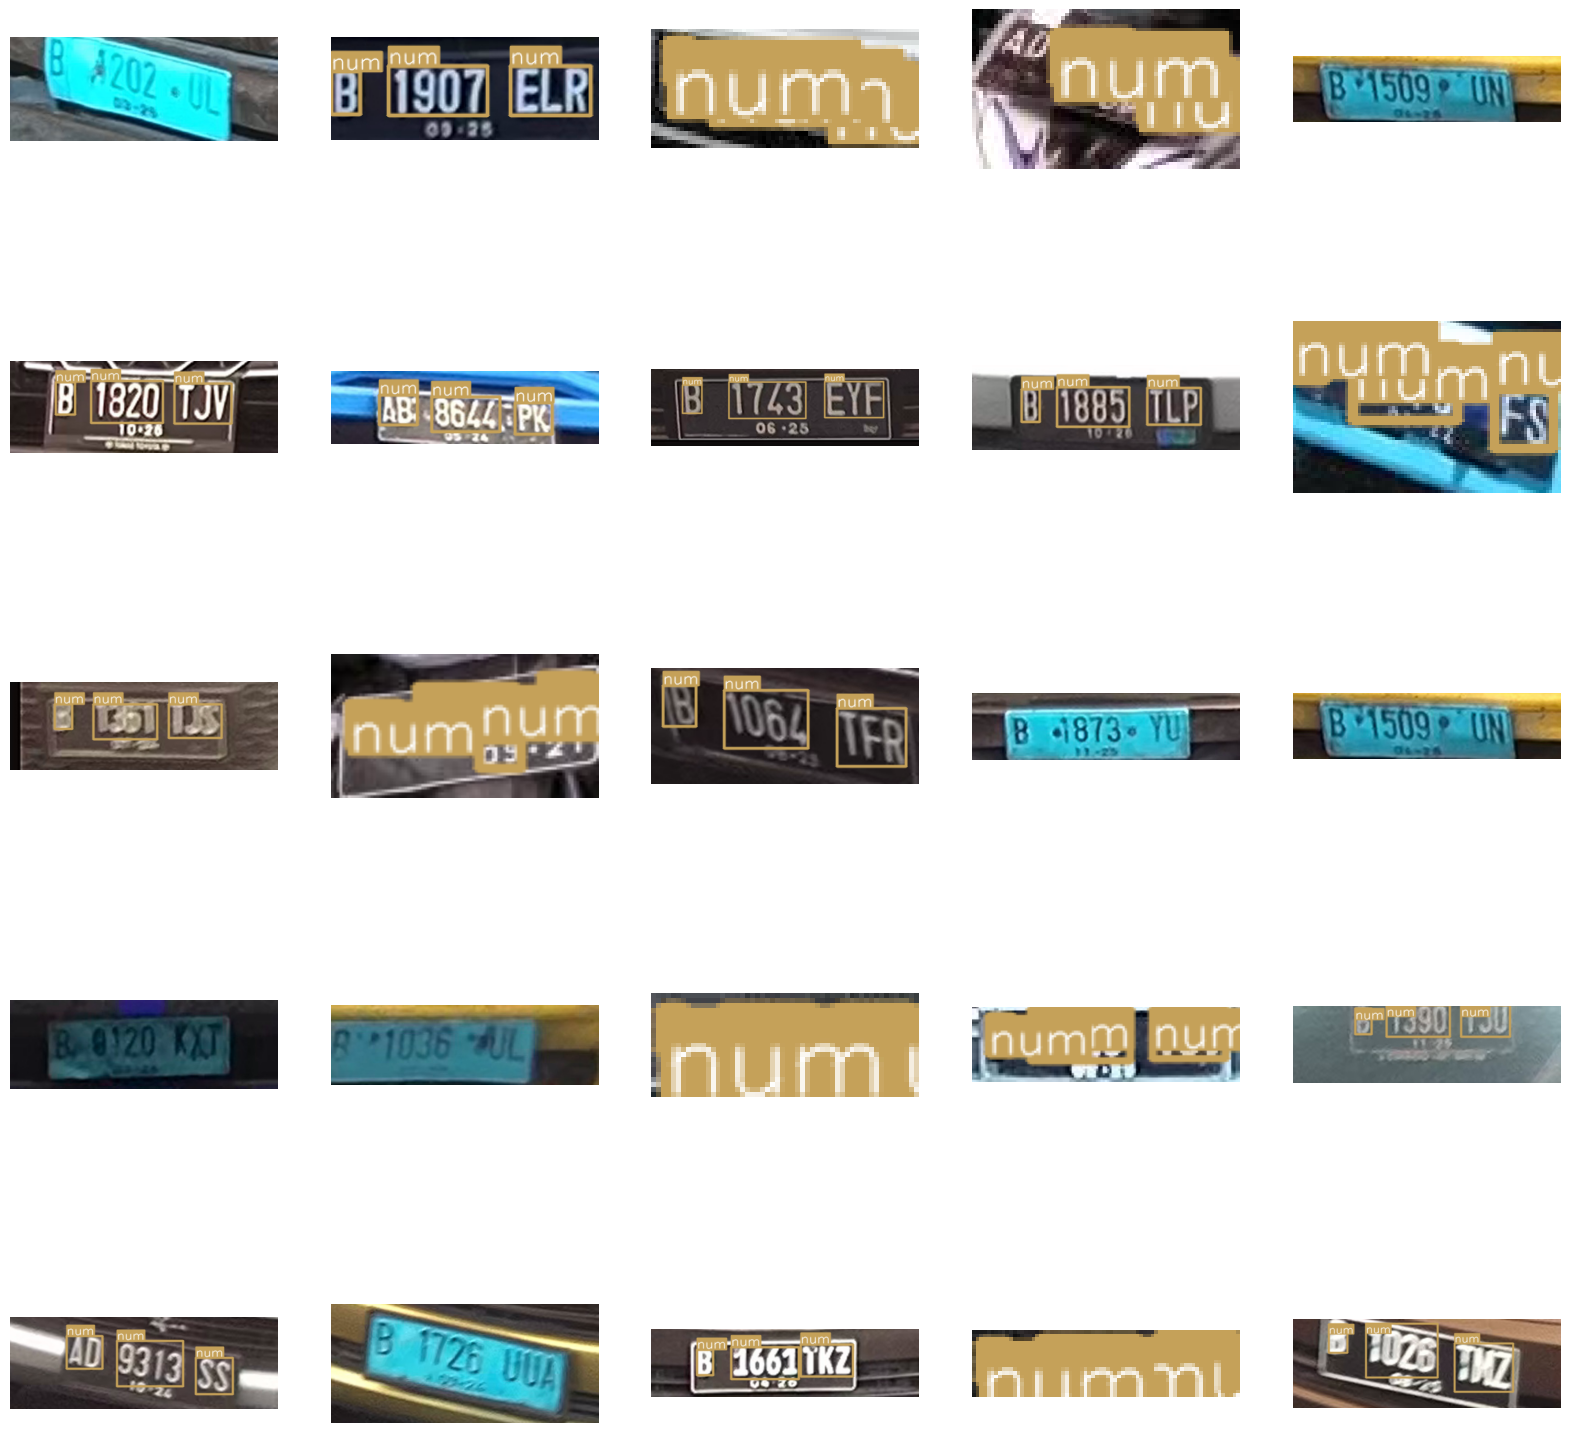

In [ ]:
start_index = 25
end_index = 50

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i, filepath in enumerate(img_fns[start_index:end_index]):
    ind = img_fns.index(filepath)
    axs[i].imshow(plot_bboxes(images[ind], results[ind].boxes.data, score=False))
    axs[i].axis('off')
plt.show()